# Bugzilla Severity Detection

## Brief introduction about bug report status

**RESOLVED**

     **RESOLVED**

     A resolution has been taken, and it is awaiting verification by QA.
     From here bugs are either re-opened and become REOPENED, are marked
     VERIFIED, or are closed for good and marked CLOSED.SED.
     
**VERIFIED**

     QA has looked at the bug and the resolution and agrees that the
     appropriate resolution has been taken. Bugs remain in this state
     until the product they were reported against actually ships, at
     which point they become CLOSED.
     
**CLOSED**

     The bug is considered dead, the resolution is correct. Any zombie
     bugs who choose to walk the earth again must do so by becoming
     REOPENED.

## Imports

In [18]:
import csv
import re
import json
import numpy as np
import os
import pandas as pd
import sys
import warnings
import re
import itertools

from sklearn.manifold import *
from sklearn.svm import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim import *
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import *

from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.naive_bayes import *
from sklearn.model_selection import *
%matplotlib inline
warnings.filterwarnings("ignore")

## Retrieving data from preprocessed csv files

In [19]:
verified = pd.read_csv('summaryList.csv', error_bad_lines=False, quotechar="'", encoding='utf-8')
print("Total number of sentences: ", verified.size)
verified.head(5)

Total number of sentences:  58430


,summary,severity,status,assigned_to,bug_id
0,[regression] all font-weight are displayed as ...,normal,VERIFIED,masayuki@d-toybox.com,365613
1,getter/setter bytecodes assume number of atoms...,normal,VERIFIED,igor@mir2.org,365692
2,"JS_Assert(char * s = 0x1012279c ""!flbase[flind...",critical,VERIFIED,general@js.bugs,365716
3,[FIX]Combobox popups don't have the width of t...,minor,VERIFIED,bzbarsky@mit.edu,365837
4,Add a strict warning for when an object litera...,enhancement,VERIFIED,mrbkap@mozilla.com,365869


## Multiclass text classification using tf-idf scores of documents

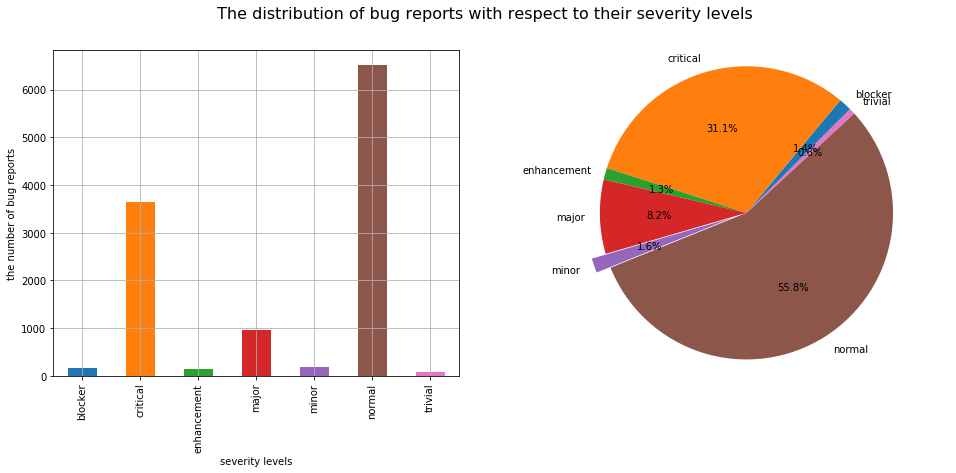

In [20]:
severity_count = verified.groupby(['severity']).size()  # returns a series object
total = severity_count.sum()
severity_percentage = severity_count / total * 100
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
explode = ( 0,0,0,0,0.1, 0, 0)

ax1 = severity_count.plot("bar", ax=axes[0])
ax1.set_ylabel("the number of bug reports")
ax1.set_xlabel("severity levels")
ax1.grid(True)

ax2 = severity_percentage.plot("pie", ax=axes[1], explode=explode, autopct='%1.1f%%', startangle=45)
ax2.set_ylabel("")
ax2.axis("equal")

plt.suptitle('The distribution of bug reports with respect to their severity levels', fontsize=16)
plt.show()

In [21]:
summaries = [verified.values[id][0] for id in range(len(verified.values))]
severities = [verified.values[id][1] for id in range(len(verified.values))]

In [22]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
tokenized = [clean_str(s).split() for s in summaries]

In [23]:
vectorizer = TfidfVectorizer(analyzer='word',tokenizer=word_tokenize, stop_words='english', lowercase=True)
tvec_weights = vectorizer.fit_transform(summaries)
X = tvec_weights.todense()
Y = np.asarray(severities)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

### Multinomial Naive Bayes

In [25]:
MultiNB = MultinomialNB()
MultiNB.fit(X_train, Y_train)

scores = cross_val_score(MultiNB, X_test, Y_test, cv=5, n_jobs=-1)

print(MultiNB)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy: 0.73 (+/- 0.04)


In [26]:
Y_expect = Y_test
Y_predict = MultiNB.predict(X_test)
print("Accuracy: %4.2f " % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

Accuracy: 0.75 
[[  0   7   0   0   0  15   0]
 [  0 265   0   0   0  96   0]
 [  0   0   0   0   0  20   0]
 [  0   7   0   0   0  85   0]
 [  0   1   0   0   0  20   0]
 [  0  36   0   0   0 612   0]
 [  0   0   0   0   0   5   0]]
[ 0.    0.73  0.    0.    0.    0.94  0.  ]
[ 0.    0.84  0.    0.    0.    0.72  0.  ]


### Linear SVM

In [27]:
lsvm = LinearSVC(dual=False, max_iter=10000)
lsvm.fit(X_train, Y_train)

scores = cross_val_score(lsvm, X_test, Y_test, cv=5, n_jobs=-1)

print(lsvm)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.76 (+/- 0.04)
[ 0.79  0.74  0.76  0.76  0.77]


In [28]:
Y_expect = Y_test
Y_predict = lsvm.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

Accuracy: 0.77
[[  1   7   0   2   0  12   0]
 [  0 290   0   1   0  70   0]
 [  0   0   0   0   0  20   0]
 [  0  11   0   6   0  75   0]
 [  0   1   0   0   0  19   1]
 [  0  36   3   9   0 600   0]
 [  0   0   0   0   0   4   1]]
[ 0.05  0.8   0.    0.07  0.    0.93  0.2 ]
[ 1.    0.84  0.    0.33  0.    0.75  0.5 ]


## Classification among severe class

In [29]:
df3 = verified.copy()
sev = ['major', 'critical', 'blocker']
df3 = df3.loc[df3['severity'].isin(sev)]
df3.loc[df3.severity == 'blocker', 'severity'] = "critical"
df3.head(5)

,summary,severity,status,assigned_to,bug_id
2,"JS_Assert(char * s = 0x1012279c ""!flbase[flind...",critical,VERIFIED,general@js.bugs,365716
9,large script miscompiles,critical,VERIFIED,igor@mir2.org,366122
10,compiling long XML filtering predicate hangs,critical,VERIFIED,igor@mir2.org,366123
15,Any use of setter functions causes an assertio...,critical,VERIFIED,brendan@mozilla.org,366288
17,[reflow branch] Crash [@ PresShell::ProcessRef...,critical,VERIFIED,mats@mozilla.com,366320


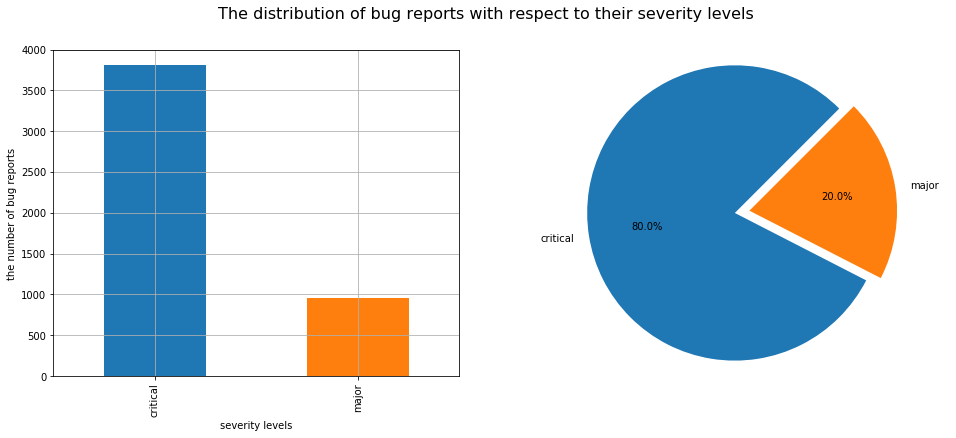

In [30]:
severity_count = df3.groupby(['severity']).size()  # returns a series object
total = severity_count.sum()
severity_percentage = severity_count / total * 100
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
explode = (0.1, 0)

ax1 = severity_count.plot("bar", ax=axes[0])
ax1.set_ylabel("the number of bug reports")
ax1.set_xlabel("severity levels")
ax1.grid(True)

ax2 = severity_percentage.plot("pie", ax=axes[1], explode=explode, autopct='%1.1f%%', startangle=45)
ax2.set_ylabel("")
ax2.axis("equal")

plt.suptitle('The distribution of bug reports with respect to their severity levels', fontsize=16)
plt.show()

In [31]:
summaries = [df3.values[id][0] for id in range(len(df3.values))]
severities = [df3.values[id][1] for id in range(len(df3.values))]

In [32]:
vectorizer = TfidfVectorizer(analyzer='word',tokenizer=word_tokenize, stop_words='english', lowercase=True)
tvec_weights = vectorizer.fit_transform(summaries)
X = tvec_weights.todense()
Y = np.asarray(severities)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [33]:
MultiNB = MultinomialNB()
MultiNB.fit(X_train, Y_train)

scores = cross_val_score(MultiNB, X_test, Y_test, cv=5, n_jobs=-1)

print(MultiNB)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Y_expect = Y_test
Y_predict = MultiNB.predict(X_test)
print("Accuracy: %4.2f " % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy: 0.82 (+/- 0.01)
Accuracy: 0.85 
[[389   3]
 [ 69  15]]
[ 0.99  0.18]
[ 0.85  0.83]


In [34]:
lsvm = LinearSVC(dual=False, max_iter=10000)
lsvm.fit(X_train, Y_train)

scores = cross_val_score(lsvm, X_test, Y_test, cv=5, n_jobs=-1)

print(lsvm)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

Y_expect = Y_test
Y_predict = lsvm.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.84 (+/- 0.04)
[ 0.83  0.82  0.85  0.83  0.87]
Accuracy: 0.89
[[369  23]
 [ 31  53]]
[ 0.94  0.63]
[ 0.92  0.7 ]


## Binary class text classification using tf-idf scores of documents

In [35]:
df1 = verified.copy()

df1.loc[df1.severity == 'blocker', 'severity'] = "severe"
df1.loc[df1.severity == 'critical', 'severity'] = "severe"
df1.loc[df1.severity == 'major', 'severity'] = "severe"

df1.loc[df1.severity == 'normal', 'severity'] = "non-severe"
df1.loc[df1.severity == 'minor', 'severity'] = "non-severe"
df1.loc[df1.severity == 'enhancement', 'severity'] = "non-severe"
df1.loc[df1.severity == 'trivial', 'severity'] = "non-severe"

df1.head()

,summary,severity,status,assigned_to,bug_id
0,[regression] all font-weight are displayed as ...,non-severe,VERIFIED,masayuki@d-toybox.com,365613
1,getter/setter bytecodes assume number of atoms...,non-severe,VERIFIED,igor@mir2.org,365692
2,"JS_Assert(char * s = 0x1012279c ""!flbase[flind...",severe,VERIFIED,general@js.bugs,365716
3,[FIX]Combobox popups don't have the width of t...,non-severe,VERIFIED,bzbarsky@mit.edu,365837
4,Add a strict warning for when an object litera...,non-severe,VERIFIED,mrbkap@mozilla.com,365869


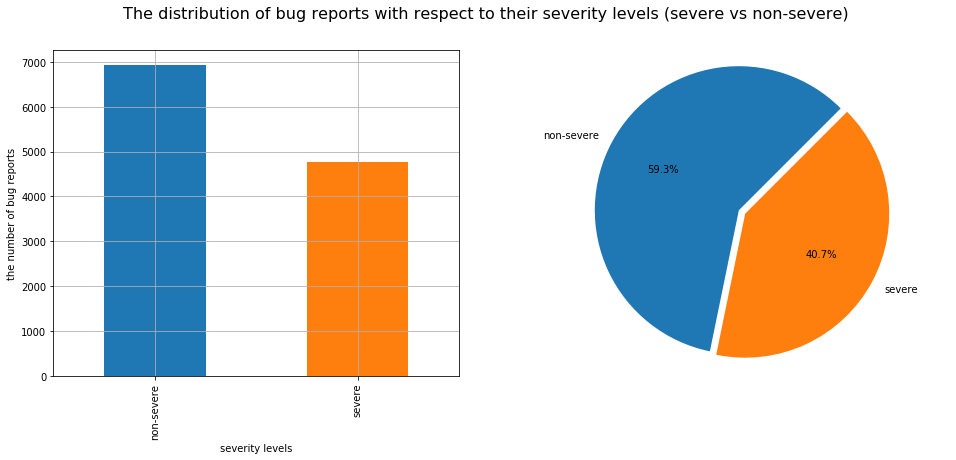

In [36]:
severity_count = df1.groupby(['severity']).size()  # returns a series object
total = severity_count.sum()
severity_percentage = severity_count / total * 100
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
explode = (0, 0.05,)

ax1 = severity_count.plot("bar", ax=axes[0])
ax1.set_ylabel("the number of bug reports")
ax1.set_xlabel("severity levels")
ax1.grid(True)

ax2 = severity_percentage.plot("pie", ax=axes[1], explode=explode, autopct='%1.1f%%', startangle=45)
ax2.set_ylabel("")
ax2.axis("equal")

plt.suptitle('The distribution of bug reports with respect to their severity levels (severe vs non-severe)',
             fontsize=16)
plt.show()

In [37]:
summaries = [df1.values[id][0] for id in range(len(df1.values))]
severities = [df1.values[id][1] for id in range(len(df1.values))]

In [38]:
vectorizer = TfidfVectorizer(analyzer='word',tokenizer=word_tokenize, stop_words='english', lowercase=True)
tvec_weights = vectorizer.fit_transform(summaries)
X = tvec_weights.todense()
Y = np.asarray(severities)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

### Multinomial Naive Bayes

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
MultiNB = MultinomialNB()
MultiNB.fit(X_train, Y_train)

scores = cross_val_score(MultiNB, X_test, Y_test, cv=5, n_jobs=-1)

print(MultiNB)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy: 0.81 (+/- 0.05)


In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
MultiNB = MultinomialNB()
MultiNB.fit(X_train, Y_train)

scores = cross_val_score(MultiNB, X_test, Y_test, cv=5, n_jobs=-1)

print(MultiNB)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
Y_expect = Y_test
Y_predict = MultiNB.predict(X_test)
print("Accuracy: %4.2f " % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy: 0.82 (+/- 0.06)
Accuracy: 0.83 
[[652  30]
 [164 323]]
[ 0.96  0.66]
[ 0.8   0.92]


In [49]:
class_names = ["non-severe", "severe"]

### Linear SVM

In [50]:
lsvm = LinearSVC(dual=False)
lsvm.fit(X_train, Y_train)

scores = cross_val_score(lsvm, X_test, Y_test, cv=10, n_jobs=-1)

print(lsvm)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.84 (+/- 0.08)


In [51]:
Y_expect = Y_test
Y_predict = lsvm.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

Accuracy: 0.83
[[627  55]
 [141 346]]
[ 0.92  0.71]
[ 0.82  0.86]


Confusion matrix, without normalization
[[1256  130]
 [ 342  610]]


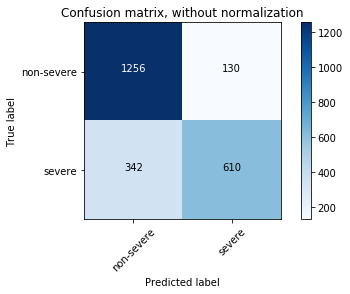

Confusion matrix, without normalization
[[1183  203]
 [ 311  641]]


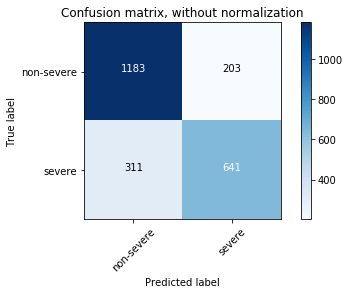

Confusion matrix, without normalization
[[1278  107]
 [ 284  668]]


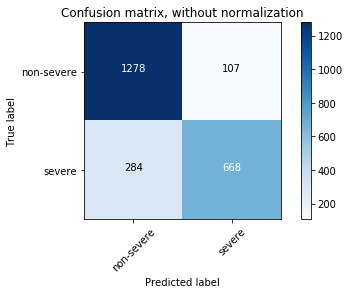

Confusion matrix, without normalization
[[1207  178]
 [ 202  750]]


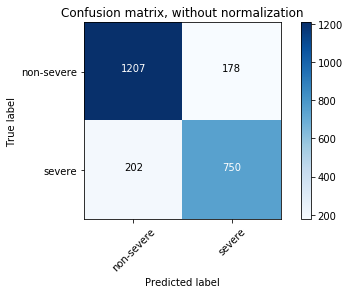

Confusion matrix, without normalization
[[1239  146]
 [ 309  642]]


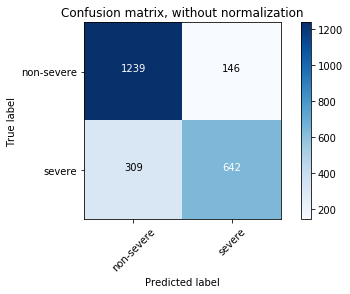

Average accuracy:  0.810716897781


In [52]:
skf = StratifiedKFold(n_splits=5)
count=0
total_acc = 0
M = X
y = Y

for train_index, test_index in skf.split(M,y):
    count +=1
    x_train, x_test = M[train_index], M[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lsvm.fit(x_train, y_train)
    y_predict = lsvm.predict(x_test)
    total_acc += accuracy_score(y_test, y_predict)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    plt.show()

print("Average accuracy: ", total_acc/count)

In [53]:
scores

array([ 0.81,  0.8 ,  0.82,  0.84,  0.85,  0.83,  0.87,  0.91,  0.87,  0.77])

### Logistic Regression

In [54]:
lr = LogisticRegression(dual=False)
lr.fit(X_train, Y_train)

scores = cross_val_score(lr, X_test, Y_test, cv=5, n_jobs=-1)

print(lr)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy: 0.82 (+/- 0.06)


In [55]:
Y_expect = Y_test
Y_predict = lr.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

Accuracy: 0.85
[[649  33]
 [148 339]]
[ 0.95  0.7 ]
[ 0.81  0.91]


Confusion matrix, without normalization
[[1306   80]
 [ 359  593]]


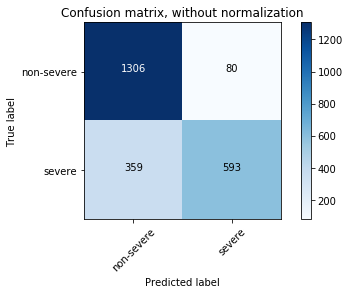

Confusion matrix, without normalization
[[1251  135]
 [ 327  625]]


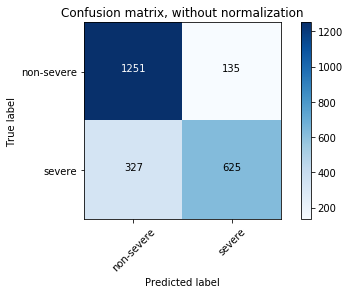

Confusion matrix, without normalization
[[1338   47]
 [ 304  648]]


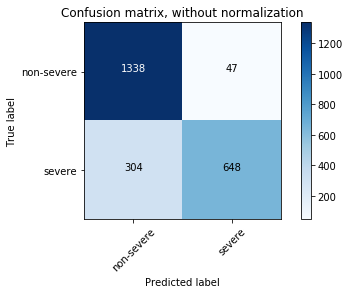

Confusion matrix, without normalization
[[1273  112]
 [ 221  731]]


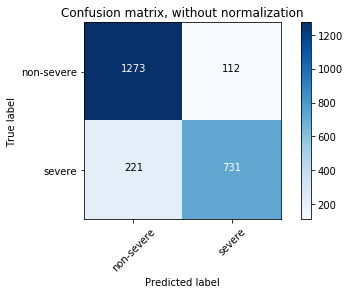

Confusion matrix, without normalization
[[1294   91]
 [ 332  619]]


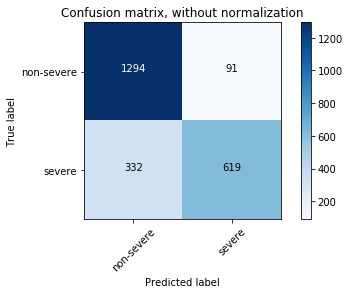

Average accuracy:  0.828173238626


In [56]:
skf = StratifiedKFold(n_splits=5)
count=0
total_acc = 0
M = X
y = Y

for train_index, test_index in skf.split(M,y):
    count +=1
    x_train, x_test = M[train_index], M[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(x_train, y_train)
    y_predict = lr.predict(x_test)
    total_acc += accuracy_score(y_test, y_predict)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    plt.show()

print("Average accuracy: ", total_acc/count)

## Feature extraction using gensim

In [ ]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors

    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This method sums all wordvecs of all words in a sentences
        and divides the resulting vector by the len of word count in the sentence
        """
        return np.array([np.sum([self.word2vec[w] for w in words if w in self.word2vec] or
                                [np.zeros(100)], axis=0) / len(words) for words in X ])

In [ ]:
sentences = [clean_str(s).split(" ") for s in summaries]
severities = [df1.values[id][1] for id in range(len(df1.values))]

model = models.Word2Vec(sentences, size=100, workers=-1, iter=1000)
words = list(model.wv.vocab)
model.wv.save_word2vec_format('model.bin')
# model = models.Word2Vec.load('model.bin')

In [ ]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))
mev = MeanEmbeddingVectorizer(w2v)
vec_weights = mev.transform(sentences)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(vec_weights, severities, test_size=0.1)

In [ ]:
X_train.shape

### Linear SVM

In [ ]:
lsvm = LinearSVC()
lsvm.fit(X_train, Y_train)

scores = cross_val_score(lsvm, X_test, Y_test, cv=5, n_jobs=-1)

print(lsvm)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
Y_expect = Y_test
Y_predict = lsvm.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

### Logistic Regression

In [ ]:
lr = LogisticRegression(dual=False)
lr.fit(X_train, Y_train)

scores = cross_val_score(lr, X_test, Y_test, cv=5, n_jobs=-1)

print(lr)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
Y_expect = Y_test
Y_predict = lr.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

In [ ]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(Y_train)

pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)
plt.figure()
colors = ['red', 'yellow']
lw = 2
target_names = np.array(["non-severe", "severe"])
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of features')

plt.show()

## Iteratively checking every classes

In [ ]:
def check_iteratively(class1, class2):
    df4 = df.copy()
#     df4 = pd.read_csv('summaryListResolved.csv', error_bad_lines=False, quotechar="'", encoding='utf-8')
    df4 = df4.loc[(df4['severity'] == class1) | (df4['severity'] == class2)]
    print(class1.upper() + ' + ' + class2.upper())
    print("*************************")
    print(df4.groupby(['severity']).size())

    summaries = [df4.values[id][0] for id in range(len(df4.values))]
    severities = [df4.values[id][1] for id in range(len(df4.values))]

    vectorizer = TfidfVectorizer(analyzer='word',tokenizer=word_tokenize, stop_words='english', lowercase=True)
    tvec_weights = vectorizer.fit_transform(summaries)
    X = tvec_weights.todense()
    Y = np.asarray(severities)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

    lsvm = LinearSVC(dual=False, max_iter=10000)
    lsvm.fit(X_train, Y_train)

    scores = cross_val_score(lsvm, X_test, Y_test, cv=5, n_jobs=-1)

    print(lsvm)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print(scores)
    Y_expect = Y_test
    Y_predict = lsvm.predict(X_test)
    print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
    print(confusion_matrix(Y_expect, Y_predict))
    print("recall_score: ", recall_score(Y_expect, Y_predict, average=None))
    print("precision_score: "precision_score(Y_expect, Y_predict,average=None))

In [ ]:
check_iteratively('enhancement', 'trivial')
check_iteratively('trivial', 'minor')
check_iteratively('minor', 'normal')
check_iteratively('normal', 'major')
check_iteratively('major', 'critical')
check_iteratively('critical', 'blocker')

In [ ]:
check_iteratively('enhancement', 'trivial')
check_iteratively('trivial', 'minor')
check_iteratively('minor', 'normal')
check_iteratively('normal', 'major')
check_iteratively('major', 'critical')
check_iteratively('critical', 'blocker')

## Using word vectors as features

In [57]:
from sentiment import *

In [58]:
df5 = verified.copy()
summaries = [df5.values[id][0] for id in range(len(df5.values))]
severities = [df5.values[id][1] for id in range(len(df5.values))]
    
summary_arr = summaries
summary_arr = convert_tolower(summary_arr)
summary_arr = remove_punctuation(summary_arr)
tokenized = tokenize_sentences(summary_arr)
# documents = remove_stopwords(summary_arr, tokenized)
# stemmed = stem_words(summary_arr, documents)

In [59]:
stemmed = tokenized

In [60]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors

    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This method sums all wordvecs of all words in a sentences
        and divides the resulting vector by the len of word count in the sentence
        """
        return np.array([np.sum([self.word2vec[w] for w in words if w in self.word2vec] or
                                [np.zeros(100)], axis=0) / len(words) for words in X ])

In [62]:
sentences = stemmed

model = models.Word2Vec(sentences, size=100, workers=-1, iter=1000)
words = list(model.wv.vocab)
model.wv.save_word2vec_format('model.bin')
# model = models.Word2Vec.load('model.bin')

w2v = dict(zip(model.wv.index2word, model.wv.syn0))
mev = MeanEmbeddingVectorizer(w2v)


X_train, X_test, Y_train, Y_test = train_test_split(vec_weights, severities, test_size=0.1)

In [63]:
vec_weights

array([[ -1.88e-04,  -1.65e-05,  -8.55e-04, ...,  -5.69e-04,  -6.03e-04,
          1.20e-03],
       [ -1.91e-05,  -7.02e-05,   1.57e-04, ...,   6.53e-04,   8.13e-04,
         -5.07e-04],
       [ -3.15e-04,   9.49e-04,   7.78e-04, ...,   6.82e-04,   9.34e-04,
          5.19e-04],
       ..., 
       [  1.39e-03,  -9.60e-05,  -1.21e-03, ...,   7.07e-04,   1.49e-03,
          5.80e-05],
       [  2.03e-04,  -8.10e-04,   1.84e-04, ...,  -2.93e-04,  -2.00e-04,
         -7.95e-04],
       [ -9.65e-04,   1.41e-03,  -7.03e-04, ...,  -1.53e-03,   1.16e-04,
          2.13e-04]])

In [64]:
lsvm = LinearSVC(max_iter=5000)
lsvm.fit(X_train, Y_train)

scores = cross_val_score(lsvm, X_test, Y_test, cv=5, n_jobs=-1)

print(lsvm)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Y_expect = Y_test
Y_predict = lsvm.predict(X_test)
print("Accuracy: %4.2f" % (accuracy_score(Y_expect, Y_predict)))
print(confusion_matrix(Y_expect, Y_predict))
print(recall_score(Y_expect, Y_predict, average=None))
print(precision_score(Y_expect, Y_predict,average=None))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.54 (+/- 0.01)
Accuracy: 0.58
[[  0   1   0   0   0  22   0]
 [  0  48   0   0   0 324   0]
 [  0   0   0   0   0  17   0]
 [  0   0   0   0   0  91   0]
 [  0   0   0   0   0  20   0]
 [  0   3   0   0   0 633   0]
 [  0   0   0   0   0  10   0]]
[ 0.    0.13  0.    0.    0.    1.    0.  ]
[ 0.    0.92  0.    0.    0.    0.57  0.  ]


## Sklearn Neural Networks

In [65]:
df7 = verified.copy()

df7.loc[df7.severity == 'blocker', 'severity'] = "severe"
df7.loc[df7.severity == 'critical', 'severity'] = "severe"
df7.loc[df7.severity == 'major', 'severity'] = "severe"

df7.loc[df7.severity == 'normal', 'severity'] = "normal"

df7.loc[df7.severity == 'minor', 'severity'] = "non-severe"
df7.loc[df7.severity == 'enhancement', 'severity'] = "non-severe"
df7.loc[df7.severity == 'trivial', 'severity'] = "non-severe"

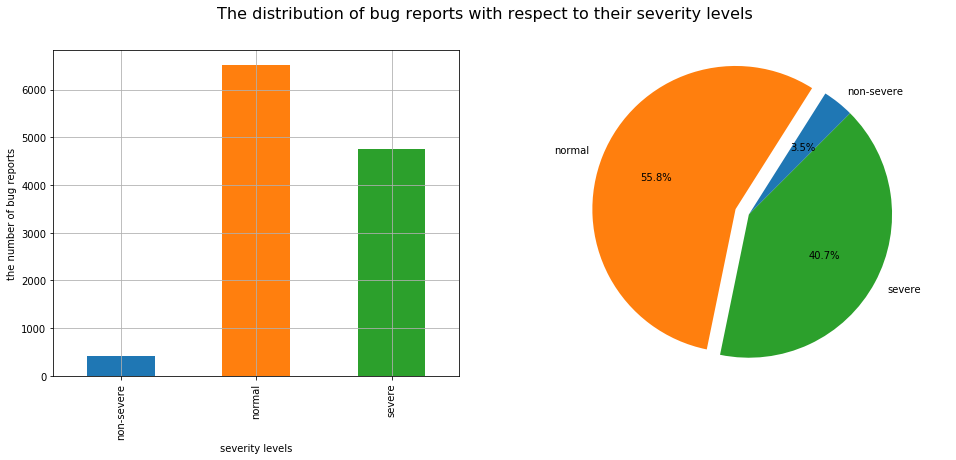

In [66]:
severity_count = df7.groupby(['severity']).size()  # returns a series object
total = severity_count.sum()
severity_percentage = severity_count / total * 100
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
explode = ( 0,0.1, 0)

ax1 = severity_count.plot("bar", ax=axes[0])
ax1.set_ylabel("the number of bug reports")
ax1.set_xlabel("severity levels")
ax1.grid(True)

ax2 = severity_percentage.plot("pie", ax=axes[1], explode=explode, autopct='%1.1f%%', startangle=45)
ax2.set_ylabel("")
ax2.axis("equal")

plt.suptitle('The distribution of bug reports with respect to their severity levels', fontsize=16)
plt.show()

In [67]:
summaries = [df7.values[id][0] for id in range(len(df7.values))]
severities = [df7.values[id][1] for id in range(len(df7.values))]

In [68]:
nn = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='lbfgs',random_state=1,
                   verbose=True, early_stopping=False, max_iter=1000)

In [69]:
class_names = ["non-severe", "normal", " severe"]

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   4   71    8]
 [   3 1151  149]
 [   0  435  517]]
Normalized confusion matrix
[[ 0.05  0.86  0.1 ]
 [ 0.    0.88  0.11]
 [ 0.    0.46  0.54]]


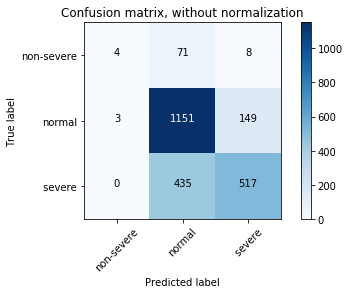

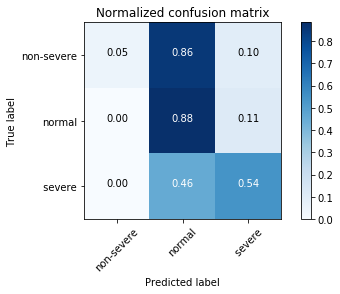

Confusion matrix, without normalization
[[   0   71   12]
 [   5 1102  196]
 [   0  399  553]]
Normalized confusion matrix
[[ 0.    0.86  0.14]
 [ 0.    0.85  0.15]
 [ 0.    0.42  0.58]]


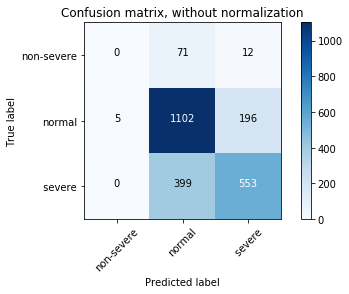

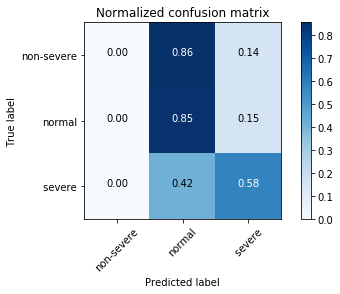

Confusion matrix, without normalization
[[   5   68    9]
 [   4 1182  117]
 [   2  322  628]]
Normalized confusion matrix
[[ 0.06  0.83  0.11]
 [ 0.    0.91  0.09]
 [ 0.    0.34  0.66]]


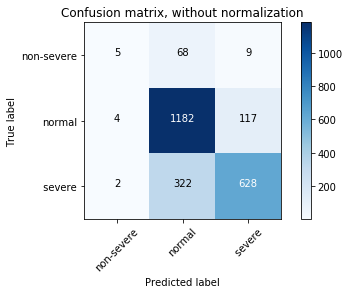

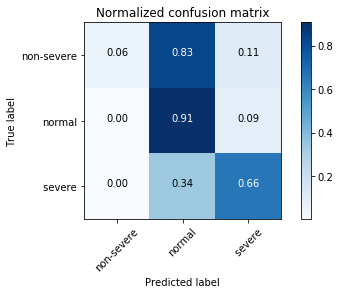

Confusion matrix, without normalization
[[   3   76    3]
 [   3 1138  162]
 [   0  250  702]]
Normalized confusion matrix
[[ 0.04  0.93  0.04]
 [ 0.    0.87  0.12]
 [ 0.    0.26  0.74]]


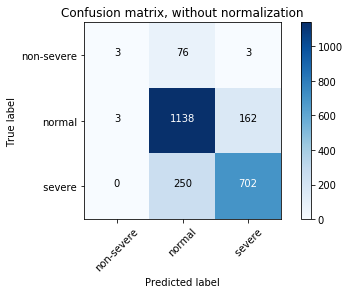

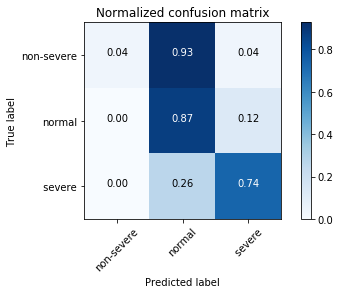

Confusion matrix, without normalization
[[   0   78    4]
 [   0 1186  117]
 [   0  380  571]]
Normalized confusion matrix
[[ 0.    0.95  0.05]
 [ 0.    0.91  0.09]
 [ 0.    0.4   0.6 ]]


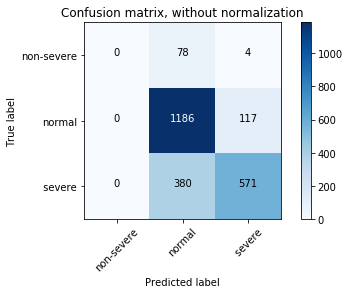

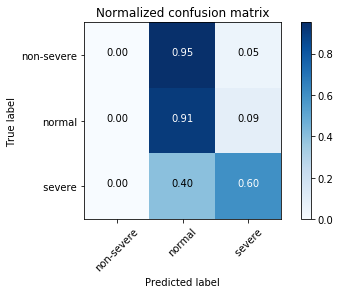

Average accuracy:  0.748081226298


In [71]:
skf = StratifiedKFold(n_splits=5)
count=0
total_acc = 0
M = vec_weights
y = severities
y = np.asarray(y)
for train_index, test_index in skf.split(M,y):
    count +=1
    x_train, x_test = M[train_index], M[test_index]
    y_train, y_test = y[train_index], y[test_index]
    nn.fit(x_train, y_train)
    y_predict = nn.predict(x_test)
    total_acc += accuracy_score(y_test, y_predict)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

print("Average accuracy: ", total_acc/count)